In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


# Import libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [0]:
path = "/content/gdrive/My Drive/Folio"
folder = os.listdir(path)
folder[0].split(' ')[0]

FileNotFoundError: ignored

# Sort folder

In [0]:
img = cv2.imread(os.path.join(path,folder[0]))
img.shape

(4128, 2322, 3)

A class for storing and loading images

In [1]:
#600x32x32x3
#ImageHolder.labels
class ImageHolder:
  def __init__(self):
    self.img = np.empty((0,128,128,3)).astype('uint8')
    self.labels = np.empty((0))
  def load_data(self,path):
    count = 0
    folder = os.listdir(path)
    folder.sort(key=lambda x:int(x[:2]))
    for filename in folder:
      print(count)
      count+=1
      temp_img = np.array([cv2.resize(cv2.imread(os.path.join(path,filename)),(128,128))]).astype('uint8')      
      self.img = np.r_[self.img,temp_img] 
      self.labels = np.r_[self.labels,int(filename.split(' ')[0])]
    return self

Tools for save and load object

In [2]:
def save_obj(var,file_name):
    import pickle
    with open(file_name+'.pkl','wb') as handle:
        pickle.dump(var,handle,protocol=pickle.HIGHEST_PROTOCOL)
  
def load_obj(file_name):
    import pickle
    with open(file_name+'.pkl','rb') as handle:
        return pickle.load(handle)


In [4]:
ImgHolder = ImageHolder().load_data(path)
save_obj(ImgHolder,'ImgHolder')

NameError: name 'path' is not defined

In [0]:
save_obj(ImgHolder,'ImgHolder')

In [3]:
ImgHolder = load_obj('ImgHolder')

# Extract feature with VGG-16 architecture

Load model

In [6]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
import numpy as np
np.random.seed(0)


pretrained_module = VGG16(weights='imagenet', include_top=False)
extracted_features = pretrained_module.predict(ImgHolder.img)
num_data = extracted_features.shape[0] 
feature_size = np.prod(extracted_features.shape[1:])
extracted_features = extracted_features.reshape(num_data,feature_size)


Instructions for updating:
Colocations handled automatically by placer.


In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import homogeneity_completeness_v_measure

pred = KMeans(n_clusters=32,random_state=0).fit_predict(extracted_features)

In [8]:
metrics = homogeneity_completeness_v_measure(ImgHolder.labels,pred)

In [9]:
print("Homogeneity {}\n Completeness {}\n V-measure {}".format(metrics[0],metrics[1],metrics[2]))

Homogeneity 0.8366406707590074
 Completeness 0.8660945526020148
 V-measure 0.851112865333657


# Extract features with ResNet50

In [4]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
import numpy as np

pretrained_module = ResNet50(weights='imagenet', include_top=False)
extracted_features = pretrained_module.predict(ImgHolder.img)
num_data = extracted_features.shape[0] 
feature_size = np.prod(extracted_features.shape[1:])
extracted_features = extracted_features.reshape(num_data,feature_size)

from sklearn.preprocessing import Normalizer

extracted_features = Normalizer().fit_transform(extracted_features)


Instructions for updating:
Colocations handled automatically by placer.


/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


# KMeans Clustering

In [118]:
from sklearn.cluster import KMeans

pred = KMeans(n_clusters=32,random_state=0).fit_predict(extracted_features)


In [119]:
from sklearn.metrics.cluster import homogeneity_completeness_v_measure

metrics = homogeneity_completeness_v_measure(ImgHolder.labels,pred)

print("Homogeneity {}\n Completeness {}\n V-measure {}".format(metrics[0],metrics[1],metrics[2]))

Homogeneity 0.9147213253820344
 Completeness 0.9298395698564728
 V-measure 0.9222184921379846


# DBScan

In [120]:
from sklearn.cluster import DBSCAN
# 
pred = DBSCAN(eps=0.56,min_samples=1, n_jobs = -1).fit_predict(extracted_features)


In [121]:
metrics = homogeneity_completeness_v_measure(ImgHolder.labels,pred)
print("Homogeneity {}\n Completeness {}\n V-measure {}".format(metrics[0],metrics[1],metrics[2]))

Homogeneity 0.8863535717995377
 Completeness 0.747135462427965
 V-measure 0.8108119146992636


Kết quả không được tốt lắm, do đó chúng ta sẽ đi search siêu tham số tối ưu cho bài toán 

In [10]:
eps_range = np.arange(0.4,0.65,0.01)
samples_range = np.arange(1,3,1)

In [11]:
# Grid search
best_v_measure = 0
best_param = []
for eps in eps_range:
    for samples in samples_range:
        print("eps=",eps,"\nsamples=",samples)
        
        pred = DBSCAN(eps=eps,min_samples=samples,n_clusters=32, n_jobs = -1).fit_predict(extracted_features)
        metrics = homogeneity_completeness_v_measure(ImgHolder.labels,pred)
        if (metrics[2] > best_v_measure):
            best_v_measure = metrics[2]
            print("Best v: {}".format(best_v_measure))
            best_param=[eps,samples]

            
        

eps= 0.4 
samples= 1


NameError: name 'DBSCAN' is not defined

In [116]:
print("Best param is: EPS = {}, MinPts = {}".format(best_param[0],best_param[1]))
pred = DBSCAN(eps=best_param[0],min_samples=best_param[1], n_jobs = -1).fit_predict(extracted_features)
metrics = homogeneity_completeness_v_measure(ImgHolder.labels,pred)
print("Homogeneity {}\n Completeness {}\n V-measure {}".format(metrics[0],metrics[1],metrics[2]))

Homogeneity 1.0000000000000004
 Completeness 0.5367303974560964
 V-measure 0.698535537976733


Kết quả đã khả quan hơn rất nhiều :D

# Agglomerative clustering

In [25]:
from sklearn.cluster import AgglomerativeClustering

pred = AgglomerativeClustering(n_clusters=32).fit_predict(extracted_features)

In [26]:
metrics = homogeneity_completeness_v_measure(ImgHolder.labels,pred)
print("Homogeneity {}\n Completeness {}\n V-measure {}".format(metrics[0],metrics[1],metrics[2]))

Homogeneity 0.9413735288860807
 Completeness 0.9544786511266072
 V-measure 0.947880795275365


# Spectral clustering

In [27]:
from sklearn.cluster import SpectralClustering

pred = SpectralClustering(n_clusters=32).fit_predict(extracted_features)
metrics = homogeneity_completeness_v_measure(ImgHolder.labels,pred)
print("Homogeneity {}\n Completeness {}\n V-measure {}".format(metrics[0],metrics[1],metrics[2]))


Homogeneity 0.9116479969300065
 Completeness 0.9234537144760484
 V-measure 0.9175128809777274


# Birch

In [142]:
from sklearn.cluster import Birch
# Grid search
best_params = []
branching_factors = np.arange(15,30,1)
thresholds = np.arange(0.5,0.6,0.001)
best_v_measure = 0
for branching_factor in branching_factors:
    for threshold in thresholds:
        pred = Birch(branching_factor=branching_factor,threshold=threshold,n_clusters=32).fit_predict(extracted_features)
        metrics = homogeneity_completeness_v_measure(ImgHolder.labels,pred)
        if (metrics[2] > best_v_measure):
            best_v_measure = metrics[2]
            print("Best v: {}".format(best_v_measure))
            best_params=[branching_factor,threshold]
print("Best param braching_factor = {}, threshold = {}".format(best_params[0],best_params[1]))


Best v: 0.74293124763028
Best v: 0.7805159017226135
Best v: 0.8092280491627671
Best v: 0.8143558378558606


/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (31) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (28) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (30) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (31) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n

Best v: 0.816743334949064


/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (30) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (30) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (30) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (30) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n

Best v: 0.8186578232866653


/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (29) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (31) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


Best v: 0.8212873108246744


/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (31) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (30) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (31) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (30) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n

Best v: 0.8234198016123734


/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (31) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


Best v: 0.8315786749386087


/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (30) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (31) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


Best v: 0.8326258376206793


/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (31) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (27) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (31) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


Best v: 0.8362086014745762


/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (27) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (30) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (29) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (31) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n

/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (31) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (28) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (26) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (28) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n

/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (30) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (28) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (26) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (27) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n

Best param braching_factor = 21, threshold = 0.5900000000000001


/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: ConvergenceWarning: Number of subclusters found (30) by Birch is less than (32). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


In [8]:

pred = Birch(branching_factor=21,threshold= 0.59,n_clusters=32).fit_predict(extracted_features)
metrics = homogeneity_completeness_v_measure(ImgHolder.labels,pred)
print("Homogeneity {}\n Completeness {}\n V-measure {}".format(metrics[0],metrics[1],metrics[2]))


Homogeneity 0.789828138677038
 Completeness 0.8883760144479126
 V-measure 0.8362086014745762


# Visualization

Bây giờ chúng ta sẽ thử visualize xem từng lớp của mạng CNN này rút trích được những đặc trưng trông như thế nào

In [40]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
import numpy as np

pretrained_module = VGG19(weights='imagenet', include_top=False)
extracted_features = pretrained_module.predict(ImgHolder.img)
num_data = extracted_features.shape[0] 
feature_size = np.prod(extracted_features.shape[1:])
extracted_features = extracted_features.reshape(num_data,feature_size)




80142336/80134624 [==============================] - 104s 1us/step


Ở đây chúng ta sẽ dùng hình của chiếc lá đầu tiên làm ví dụ

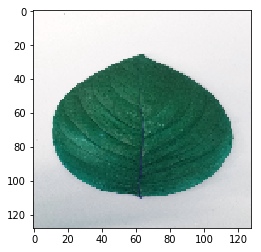

In [69]:
import matplotlib.pyplot as plt
plt.imshow(ImgHolder.img[0])

<IPython.core.display.Javascript object>


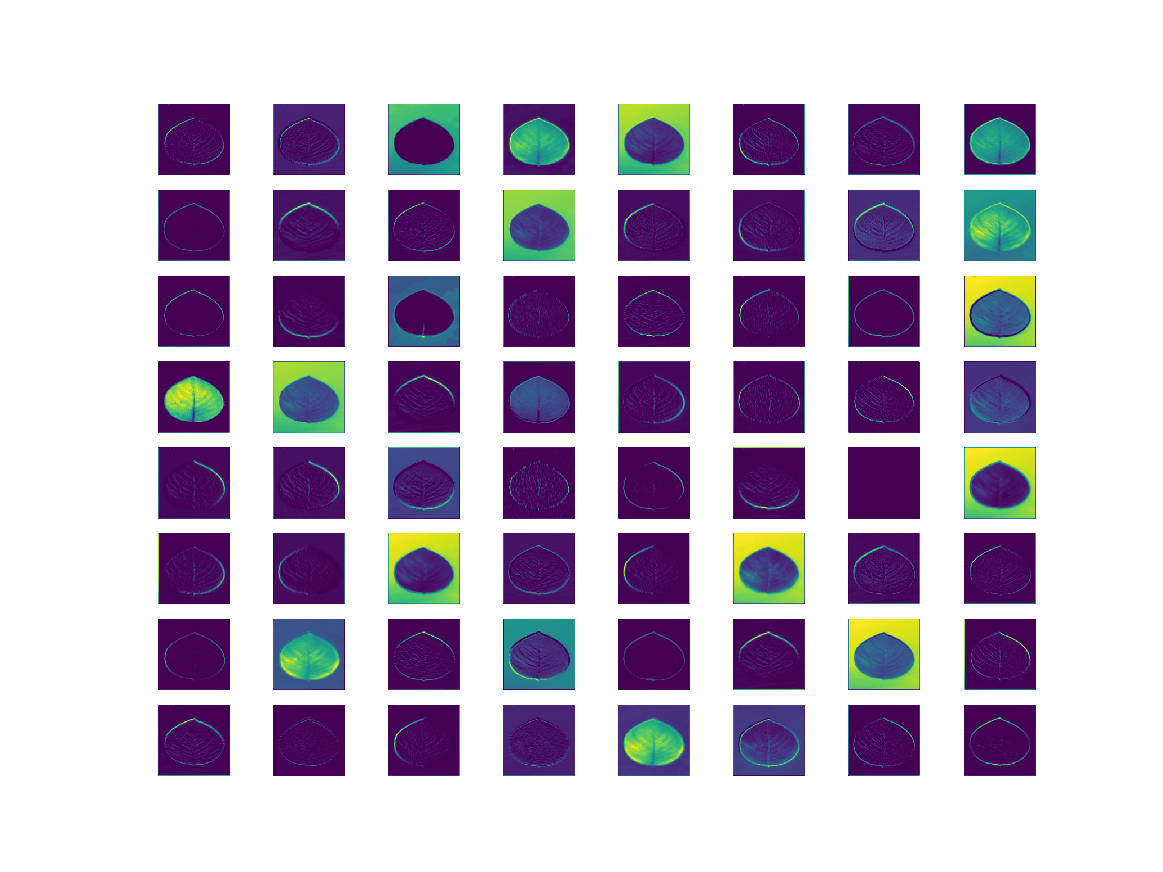

In [95]:
from tensorflow.keras.models import Model

data = np.array([ImgHolder.img[0]])

layer_name = 'block1_conv2'
intermediate_layer_model = Model(inputs=pretrained_module.input,
                                 outputs=pretrained_module.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(data)
%matplotlib notebook
num_kernels = intermediate_output[0].shape[2]

for i in range(num_kernels):
    plt.subplot(8,8,i+1)
    plt.imshow(intermediate_output[0][:,:,i])
    plt.axis('off')

<IPython.core.display.Javascript object>


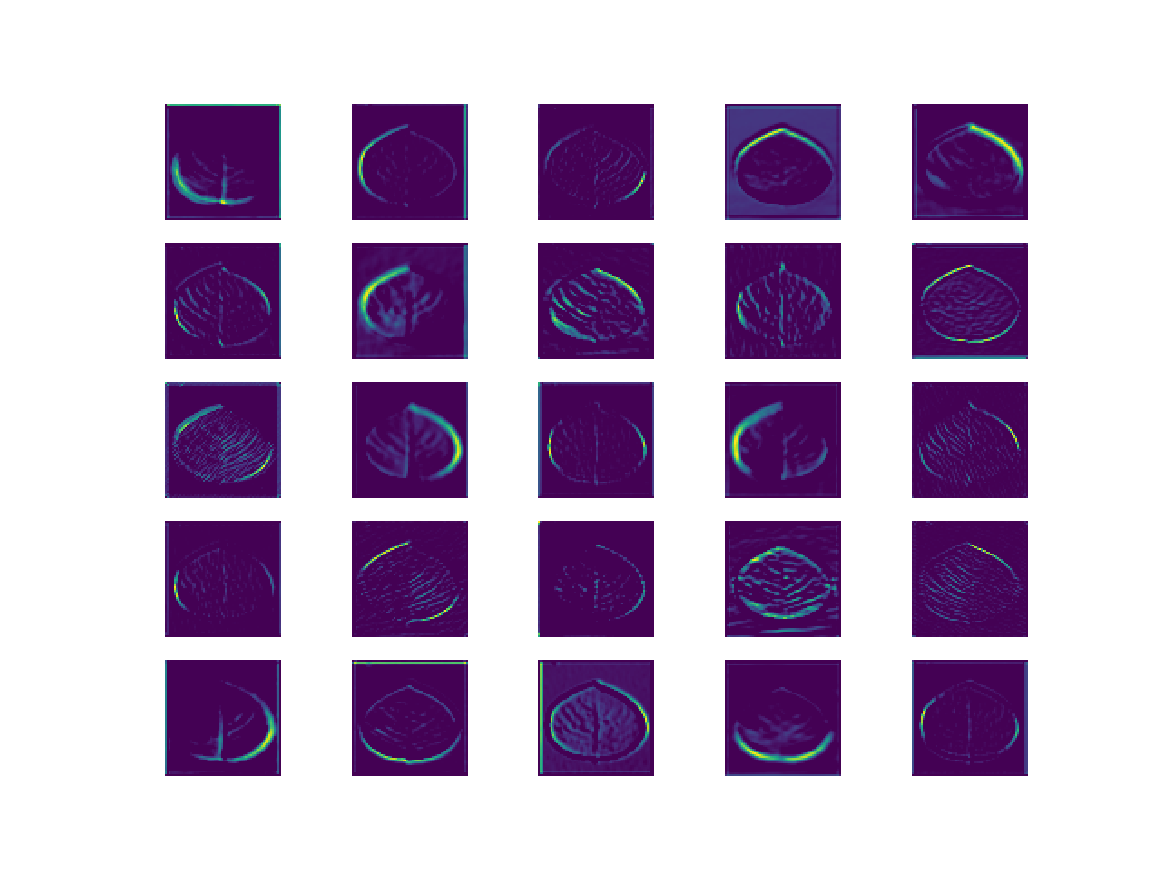

In [118]:
layer_name = 'block2_conv2'
intermediate_layer_model = Model(inputs=pretrained_module.input,
                                 outputs=pretrained_module.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(data)
%matplotlib notebook

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(intermediate_output[0][:,:,i])
    plt.axis('off')

<IPython.core.display.Javascript object>


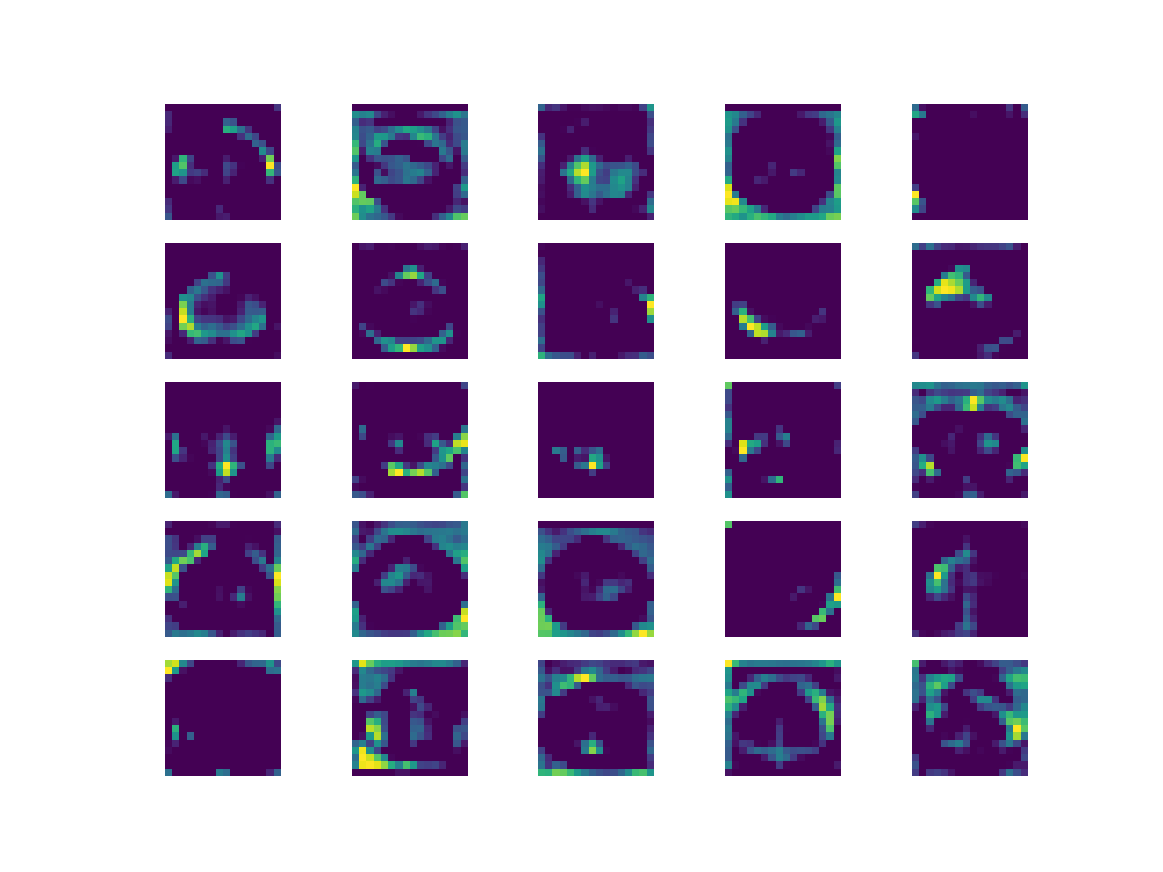

In [117]:
layer_name = 'block4_conv3'
intermediate_layer_model = Model(inputs=pretrained_module.input,
                                 outputs=pretrained_module.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(data)
%matplotlib notebook
num_kernels = intermediate_output[0].shape[2]

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(intermediate_output[0][:,:,i])
    plt.axis('off')